### Supervised Fine-Tuning

This notebook demonstrates three widely used methods for fine-tuning models from the Qwen-2.5 series. It includes steps for data preparation and tokenization tailored specifically to Qwen-2.5 models, though the underlying concepts are applicable to other model series as well.

The showcased task is a Hinglish style transfer problem, aiming to strike a balance between model size and generation quality (as evaluated in `evaluation.ipynb`). This notebook focuses solely on the fine-tuning process and saving the resulting model—either as a fully fine-tuned model or as lightweight adapters using PEFT techniques.

#### Fine-Tuning Methods Covered:

* Full fine-tuning
* LoRA (Low-Rank Adaptation)
* QLoRA (Quantized LoRA)


<img src="./assets/SFT.png" alt="SFT_techniques" height="500px"/>

*Date : 20th April 2025 | Author : Prakhar Bhartiya*

### Environment Setup and Package Installation

Before starting, install the necessary packages based on your system configuration.

PyTorch Installation

- For Windows/Linux with NVIDIA GPU (e.g., RTX 30/40/50 series or A100):Install the CUDA-enabled version of PyTorch.
    ```bash
    !pip install -qU torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128 # cuXXX at the end denotes cuda version. At time of writing 12.8 is the latest official stable cuda-pytorch
    ```

- For Apple Silicon (e.g., M1/M2):Use the PyTorch build with Metal backend acceleration.
    ```bash
    !pip install -qU torch
    ```


In [1]:
# [Nvidia - GPUs]
!pip install -qU torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

# [Apple Silicon]
# !pip install -qU torch

In [2]:
# Rest of the packages
!pip install -qU transformers datasets accelerate peft matplotlib seaborn trl hf_xet bitsandbytes

In [9]:
import os
import torch
import numpy as np
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    PeftModel
)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [3]:
# [ LoRA/QLoRA Finetune Model ]
# Base Model ID from Hugging Face - https://huggingface.co/Qwen/Qwen2.5-3B-Instruct
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"

# [ Full Finetune Model ]
MODEL_ID_FULL_FINETUNE = "Qwen/Qwen2.5-0.5B-Instruct" # Opting for smaller model(0.5B), for faster training times and show variety 

# https://huggingface.co/datasets/prakharb01/Synthetic-Hinglish-Finetuning-Dataset ; I made this dataset :}
DATASET_ID = "prakharb01/Synthetic-Hinglish-Finetuning-Dataset"

MODEL_NAME = MODEL_ID.split('/')[-1]
MODEL_NAME_FULL = MODEL_ID_FULL_FINETUNE.split('/')[-1]
print(f"LoRA/QLoRA base model : {MODEL_NAME}")
print(f"Full Finetune base model : {MODEL_NAME_FULL}")

LoRA/QLoRA base model : Qwen2.5-3B-Instruct
Full Finetune base model : Qwen2.5-0.5B-Instruct


### Loading dataset - From Huggingface

In [4]:
# [HuggingFace]
from datasets import load_dataset

# Load the dataset directly from the Hugging Face Hub
dataset = load_dataset(DATASET_ID)

In [5]:
dataset['train'][0]

{'conversation': [{'content': 'Oye, Navratri night ke liye rangoli ka kya scene hai? Mummyji toh keh rahi thi ki badi honi chahiye is baar. Aur lighting ka bhi kuch plan hai tere dimag mein, photographer sahab?',
   'role': 'user'},
  {'content': 'Haan bhai, rangoli ka design toh final hai. Thoda traditional aur thoda modern touch diya hai. Lighting mein LED strips use karenge, colorful wali. Energy bhi bachegi aur photo bhi mast aayegi, tension na le.',
   'role': 'assistant'},
  {'content': 'LED theek hai, lekin woh blink-blink wali nahi chahiye. Aankhein dukhti hain phir. Aur rangoli mein colors bright rakhna, festive feel aani chahiye. Mummyji ne bola hai ki design mein diya bhi banana hai.',
   'role': 'user'},
  {'content': "Haan, blink wali toh bilkul nahi. Steady lights hi lagayenge. Rangoli mein vibrant colors hi use kar raha hoon, aur diya wala design bhi add kar diya hai. Don't worry, mummyji ko pasand aayega pakka.",
   'role': 'assistant'},
  {'content': 'Perfect! Phir toh

### Data Prep

In [6]:
try:
    raw_dataset = dataset['train']
    print(f"Loaded dataset with {len(raw_dataset)} conversations.")
    print("Sample Conversation Structure:", raw_dataset[0]['conversation'])
    DATASET_CONVERSATION_COLUMN = "conversation" # Define the column name

except Exception as e:
    print(f"Error processing dataset : {e}")
    raise e

Loaded dataset with 3577 conversations.
Sample Conversation Structure: [{'content': 'Oye, Navratri night ke liye rangoli ka kya scene hai? Mummyji toh keh rahi thi ki badi honi chahiye is baar. Aur lighting ka bhi kuch plan hai tere dimag mein, photographer sahab?', 'role': 'user'}, {'content': 'Haan bhai, rangoli ka design toh final hai. Thoda traditional aur thoda modern touch diya hai. Lighting mein LED strips use karenge, colorful wali. Energy bhi bachegi aur photo bhi mast aayegi, tension na le.', 'role': 'assistant'}, {'content': 'LED theek hai, lekin woh blink-blink wali nahi chahiye. Aankhein dukhti hain phir. Aur rangoli mein colors bright rakhna, festive feel aani chahiye. Mummyji ne bola hai ki design mein diya bhi banana hai.', 'role': 'user'}, {'content': "Haan, blink wali toh bilkul nahi. Steady lights hi lagayenge. Rangoli mein vibrant colors hi use kar raha hoon, aur diya wala design bhi add kar diya hai. Don't worry, mummyji ko pasand aayega pakka.", 'role': 'assistant

### Data Formatting & Tokenization

![tokenization_meaning](https://miro.medium.com/v2/resize:fit:1400/1*HBCn3f7lf3ITtga3Dc20Tw.png)

*Image credit : [ypmanohar](https://medium.com/@ypmanohar.iitm/demystifying-tokenization-the-building-blocks-of-language-ai-5c1dbd5f4343)*

In [8]:
# Under the hood : How does it look?

# Qwen2.5 Models Tokenizer Pattern
# https://huggingface.co/Qwen/Qwen2.5-3B-Instruct/blob/main/tokenizer_config.json

print("{%- if tools %}\n    {{- '<|im_start|>system\\n' }}\n    {%- if messages[0]['role'] == 'system' %}\n        {{- messages[0]['content'] }}\n    {%- else %}\n        {{- 'You are Qwen, created by Alibaba Cloud. You are a helpful assistant.' }}\n    {%- endif %}\n    {{- \"\\n\\n# Tools\\n\\nYou may call one or more functions to assist with the user query.\\n\\nYou are provided with function signatures within <tools></tools> XML tags:\\n<tools>\" }}\n    {%- for tool in tools %}\n        {{- \"\\n\" }}\n        {{- tool | tojson }}\n    {%- endfor %}\n    {{- \"\\n</tools>\\n\\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\\n<tool_call>\\n{\\\"name\\\": <function-name>, \\\"arguments\\\": <args-json-object>}\\n</tool_call><|im_end|>\\n\" }}\n{%- else %}\n    {%- if messages[0]['role'] == 'system' %}\n        {{- '<|im_start|>system\\n' + messages[0]['content'] + '<|im_end|>\\n' }}\n    {%- else %}\n        {{- '<|im_start|>system\\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\\n' }}\n    {%- endif %}\n{%- endif %}\n{%- for message in messages %}\n    {%- if (message.role == \"user\") or (message.role == \"system\" and not loop.first) or (message.role == \"assistant\" and not message.tool_calls) %}\n        {{- '<|im_start|>' + message.role + '\\n' + message.content + '<|im_end|>' + '\\n' }}\n    {%- elif message.role == \"assistant\" %}\n        {{- '<|im_start|>' + message.role }}\n        {%- if message.content %}\n            {{- '\\n' + message.content }}\n        {%- endif %}\n        {%- for tool_call in message.tool_calls %}\n            {%- if tool_call.function is defined %}\n                {%- set tool_call = tool_call.function %}\n            {%- endif %}\n            {{- '\\n<tool_call>\\n{\"name\": \"' }}\n            {{- tool_call.name }}\n            {{- '\", \"arguments\": ' }}\n            {{- tool_call.arguments | tojson }}\n            {{- '}\\n</tool_call>' }}\n        {%- endfor %}\n        {{- '<|im_end|>\\n' }}\n    {%- elif message.role == \"tool\" %}\n        {%- if (loop.index0 == 0) or (messages[loop.index0 - 1].role != \"tool\") %}\n            {{- '<|im_start|>user' }}\n        {%- endif %}\n        {{- '\\n<tool_response>\\n' }}\n        {{- message.content }}\n        {{- '\\n</tool_response>' }}\n        {%- if loop.last or (messages[loop.index0 + 1].role != \"tool\") %}\n            {{- '<|im_end|>\\n' }}\n        {%- endif %}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|im_start|>assistant\\n' }}\n{%- endif %}\n")

{%- if tools %}
    {{- '<|im_start|>system\n' }}
    {%- if messages[0]['role'] == 'system' %}
        {{- messages[0]['content'] }}
    {%- else %}
        {{- 'You are Qwen, created by Alibaba Cloud. You are a helpful assistant.' }}
    {%- endif %}
    {{- "\n\n# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>" }}
    {%- for tool in tools %}
        {{- "\n" }}
        {{- tool | tojson }}
    {%- endfor %}
    {{- "\n</tools>\n\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\n<tool_call>\n{\"name\": <function-name>, \"arguments\": <args-json-object>}\n</tool_call><|im_end|>\n" }}
{%- else %}
    {%- if messages[0]['role'] == 'system' %}
        {{- '<|im_start|>system\n' + messages[0]['content'] + '<|im_end|>\n' }}
    {%- else %}
        {{- '<|im_start|>system\nYou are Qwen, created by Alibaba C

In [9]:
# Meta-Llama3.2 model series

print("{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- if strftime_now is defined %}\n        {%- set date_string = strftime_now(\"%d %b %Y\") %}\n    {%- else %}\n        {%- set date_string = \"26 Jul 2024\" %}\n    {%- endif %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0]['role'] == 'system' %}\n    {%- set system_message = messages[0]['content']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = \"\" %}\n{%- endif %}\n\n{#- System message #}\n{{- \"<|start_header_id|>system<|end_header_id|>\\n\\n\" }}\n{%- if tools is not none %}\n    {{- \"Environment: ipython\\n\" }}\n{%- endif %}\n{{- \"Cutting Knowledge Date: December 2023\\n\" }}\n{{- \"Today Date: \" + date_string + \"\\n\\n\" }}\n{%- if tools is not none and not tools_in_user_message %}\n    {{- \"You have access to the following functions. To call a function, please respond with JSON for a function call.\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n{%- endif %}\n{{- system_message }}\n{{- \"<|eot_id|>\" }}\n\n{#- Custom tools are passed in a user message with some extra guidance #}\n{%- if tools_in_user_message and not tools is none %}\n    {#- Extract the first user message so we can plug it in here #}\n    {%- if messages | length != 0 %}\n        {%- set first_user_message = messages[0]['content']|trim %}\n        {%- set messages = messages[1:] %}\n    {%- else %}\n        {{- raise_exception(\"Cannot put tools in the first user message when there's no first user message!\") }}\n{%- endif %}\n    {{- '<|start_header_id|>user<|end_header_id|>\\n\\n' -}}\n    {{- \"Given the following functions, please respond with a JSON for a function call \" }}\n    {{- \"with its proper arguments that best answers the given prompt.\\n\\n\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n    {{- first_user_message + \"<|eot_id|>\"}}\n{%- endif %}\n\n{%- for message in messages %}\n    {%- if not (message.role == 'ipython' or message.role == 'tool' or 'tool_calls' in message) %}\n        {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\\n\\n'+ message['content'] | trim + '<|eot_id|>' }}\n    {%- elif 'tool_calls' in message %}\n        {%- if not message.tool_calls|length == 1 %}\n            {{- raise_exception(\"This model only supports single tool-calls at once!\") }}\n        {%- endif %}\n        {%- set tool_call = message.tool_calls[0].function %}\n        {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n        {{- '{\"name\": \"' + tool_call.name + '\", ' }}\n        {{- '\"parameters\": ' }}\n        {{- tool_call.arguments | tojson }}\n        {{- \"}\" }}\n        {{- \"<|eot_id|>\" }}\n    {%- elif message.role == \"tool\" or message.role == \"ipython\" %}\n        {{- \"<|start_header_id|>ipython<|end_header_id|>\\n\\n\" }}\n        {%- if message.content is mapping or message.content is iterable %}\n            {{- message.content | tojson }}\n        {%- else %}\n            {{- message.content }}\n        {%- endif %}\n        {{- \"<|eot_id|>\" }}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' }}\n{%- endif %}\n")

{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- if strftime_now is defined %}
        {%- set date_string = strftime_now("%d %b %Y") %}
    {%- else %}
        {%- set date_string = "26 Jul 2024" %}
    {%- endif %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if tools is not none %}
    {{- "Environment: ipython\n" }}
{%- endif %}
{{- "Cutting Knowledge Date: December 2023\n" }}
{{- 

<img src="./assets/template.png" alt="chat-template" height="500px">

### Sequence Length Estimation for LLM Fine-Tuning

#### Why This Matters
Before fine-tuning, it's important to pick a `max_seq_length` that matches your dataset. Setting it too high wastes compute (due to padding); too low causes truncation loosing context information.

#### Solution
To estimate the appropriate sequence length based on the actual token lengths in your dataset (e.g., conversations, documents). Use the model's tokenizer to measure token counts across all samples. Then pick the **95th percentile** length as your `max_seq_length`.

#### Benefits
- **Faster training** (less padding)
- **Better memory usage**
- **Avoids context loss due to truncation**
- **Data-driven input sizing**

In [10]:
def estimate_sequence_length(conversations, model_id, percentile=95):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    lengths = [
        len(tokenizer.encode(" ".join(turn["content"] for turn in convo)))
        for convo in conversations
    ]

    return int(np.percentile(lengths, percentile))

good_seq_length = estimate_sequence_length([raw_dataset[i]["conversation"] for i in range(len(raw_dataset))], MODEL_ID)
print(good_seq_length)

348


After estimating the token length (e.g., 348), we round **up** to the next model-friendly value to optimize GPU usage.

Typical values:  
`128, 256, 384, 512, 768, 1024, 2048`

#### Why Round Up?

- Hardware optimization: GPUs are faster with input sizes like 256, 512, 1024 because of memory alignment and tensor core usage.
- Batching efficiency: Training frameworks optimize for power-of-2 shapes—less wasted memory, faster parallelism.
- Model compatibility: Pretrained models are often designed and tested with these typical lengths.

Therefore in my case, I will pick **512** as it gives a safety buffer for occasional longer samples without significant waste.

#### Additional Notes
During the pre-training phase, we aim to maximize the sequence length based on available compute resources. Foundational models are typically trained on multi-node GPU clusters, allowing for longer input contexts. Pretraining with short sequences can limit a model’s ability to generalize to longer contexts during inference.

In contrast, during fine-tuning, the focus shifts to efficiency—we select a sequence length that matches the dataset to avoid unnecessary padding and reduce computational overhead.

In [13]:
MAX_SEQ_LENGTH = 512 # Context window

# Intial System prompt for tuned model
SYSTEM_PROMPT = "You are a helpful college friend who talks only in Hinglish (a mix of Hindi and English used in urban India). Be casual, friendly, and use common Hinglish slang. Do not use formal Hindi or pure English."

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True) # As both opted models belongs to same series, they will have same tokenizer.

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print(f"Set pad_token to eos_token: {tokenizer.pad_token}")


# Define markers based on Qwen2/Qwen2.5 template structure 
# These are used to identify assistant response boundaries AFTER template application
# Note: Encoding these might yield slightly different IDs depending on context,so finding them robustly in the full sequence is key.
assistant_start_marker_str = "<|im_start|>assistant\n"
assistant_end_marker_str = "<|im_end|>"

# Tokenize the markers to get their IDs
# We encode them standalone first, but be aware context can affect tokenization slightly. It's safer to search for the *sequence* of tokens.
assistant_start_marker_ids = tokenizer.encode(assistant_start_marker_str, add_special_tokens=False)
assistant_end_marker_ids = tokenizer.encode(assistant_end_marker_str, add_special_tokens=False)

# Helper function to find sublist indices
def find_sublist_indices(main_list, sub_list):
    indices = []
    len_sub = len(sub_list)
    if len_sub == 0:
        return indices
    for i in range(len(main_list) - len_sub + 1):
        if main_list[i:i+len_sub] == sub_list:
            indices.append(i)
    return indices

def format_and_tokenize_conversation(example):
    """
    Formats a conversation list using the chat template, tokenizes it,
    and creates labels masking non-assistant parts.
    """
    conversation = example[DATASET_CONVERSATION_COLUMN]

    # 1. Add system prompt if not present
    if not conversation or conversation[0]['role'] != 'system':
        conversation.insert(0, {"role": "system", "content": SYSTEM_PROMPT})

    # 2. Apply chat template to the full conversation
    # We don't add generation prompt here; we have the full conversation
    # Truncation=False initially, we'll truncate manually later if needed
    input_ids = tokenizer.apply_chat_template(
        conversation,
        tokenize=True,
        add_generation_prompt=False,
        padding=False, # No padding yet
        truncation=False # No truncation yet
    )

    # 3. Create labels: Initialize with -100, then unmask assistant parts
    labels = [-100] * len(input_ids)

    # Find all start and end markers for assistant turns
    start_indices = find_sublist_indices(input_ids, assistant_start_marker_ids)
    end_indices = find_sublist_indices(input_ids, assistant_end_marker_ids)

    # Iterate through assistant turns identified by markers
    current_assistant_turn = 0
    for start_marker_idx in start_indices:
        # Find the corresponding end marker AFTER this start marker
        # The assistant response tokens are between the end of the start marker and the beginning of the end marker.
        assistant_content_start_index = start_marker_idx + len(assistant_start_marker_ids)

        # Find the *first* end marker that appears after assistant_content_start_index
        possible_end_marker_indices = [idx for idx in end_indices if idx >= assistant_content_start_index]
        if possible_end_marker_indices:
            assistant_content_end_index = possible_end_marker_indices[0]

            # Unmask the labels for the assistant's content tokens
            for i in range(assistant_content_start_index, assistant_content_end_index):
                if i < len(labels): # Boundary check
                    labels[i] = input_ids[i]
            current_assistant_turn += 1
        else:
            # This shouldn't happen if the template is applied correctly, but good to know :)
            print(f"Warning: Could not find matching end marker for assistant turn starting around index {start_marker_idx}.")


    # 4. Truncate sequences if they exceed max length
    if len(input_ids) > MAX_SEQ_LENGTH:
        input_ids = input_ids[:MAX_SEQ_LENGTH]
        labels = labels[:MAX_SEQ_LENGTH]

    # 5. Pad sequences
    pad_len = MAX_SEQ_LENGTH - len(input_ids)
    input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
    labels = labels + [-100] * pad_len # Pad labels with -100

    return {
        "input_ids": input_ids,
        "attention_mask": [1] * (MAX_SEQ_LENGTH - pad_len) + [0] * pad_len, # Create attention mask
        "labels": labels,
    }

# Apply the formatting and tokenization function
# Ensure original 'conversation' column is removed if not needed by Trainer
processed_dataset = raw_dataset.map(
    format_and_tokenize_conversation,
    remove_columns=[DATASET_CONVERSATION_COLUMN] # Remove original column
)

print("\nSample processed example:")
sample = processed_dataset[0]
print("Input IDs:", sample['input_ids'][:50], "...")
print("Labels:", sample['labels'][:50], "...") # Should have -100 for non-assistant parts
print("Attention Mask:", sample['attention_mask'][:50], "...")

# Decode to verify masking
decoded_input = tokenizer.decode(sample['input_ids'], skip_special_tokens=False)
print("\nDecoded Input (Full):", decoded_input)
decoded_labels_display = tokenizer.decode([l if l != -100 else tokenizer.pad_token_id for l in sample['labels']], skip_special_tokens=False)
print("\nDecoded Labels (Unmasked Parts Only):", decoded_labels_display.replace(tokenizer.pad_token, "").replace(tokenizer.eos_token, ""))

Map: 100%|██████████| 3577/3577 [00:01<00:00, 2113.57 examples/s]


Sample processed example:
Input IDs: [151644, 8948, 198, 2610, 525, 264, 10950, 7770, 4238, 879, 13433, 1172, 304, 472, 287, 1672, 320, 64, 6514, 315, 43980, 323, 6364, 1483, 304, 15662, 6747, 568, 2823, 16334, 11, 11657, 11, 323, 990, 4185, 472, 287, 1672, 79912, 13, 3155, 537, 990, 15908, 43980, 476, 10526, 6364, 13] ...
Labels: [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100] ...
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ...

Decoded Input (Full): <|im_start|>system
You are a helpful college friend who talks only in Hinglish (a mix of Hindi and English used in urban India). Be casual, friendly, and use common Hi

### Helper Functions

In [14]:
# --- Loss Plot ---
def plot_loss(history, title, filename):
    if history is None:
        print("No training history found.")
        return

    train_loss = [log.get('loss') for log in history if 'loss' in log]
    eval_loss = [log.get('eval_loss') for log in history if 'eval_loss' in log]

    train_steps = [log.get('step') for log in history if 'loss' in log]
    eval_steps = [log.get('step') for log in history if 'eval_loss' in log]

    if not train_loss or not train_steps:
        print("Training loss data not found in history.")
        return

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=train_steps, y=train_loss, label='Training Loss')
    if eval_loss and eval_steps:
        sns.lineplot(x=eval_steps, y=eval_loss, label='Validation Loss')
    plt.title(title)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{filename}.png")
    plt.show()

# --- Select correct device automatically ---
def select_device():
    device_available = ""
    if torch.cuda.is_available():
        device_available = "cuda"
    elif torch.mps.is_available():
        device_available = "mps"
    else:
        device_available = "cpu"
    return torch.device(device_available)

# --- Response Generation ---
def generate_conversational_response(model, tokenizer, conversation_history, device='cuda'):
    model.eval() # Set model to evaluation mode

    # Ensure system prompt is present
    if not conversation_history or conversation_history[0].get("role") != "system":
         conversation_history.insert(0, {"role": "system", "content": SYSTEM_PROMPT})

    input_ids = tokenizer.apply_chat_template(
        conversation_history,
        add_generation_prompt=True, # Add prompt for assistant's turn
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,                 # Input prompt token IDs
            max_new_tokens=30,                   # Maximum number of tokens to generate (response length)
            temperature=0.7,                     # Controls randomness: lower is more deterministic
            top_p=0.9,                           # Nucleus sampling: consider top tokens whose cumulative prob ≤ top_p
            top_k=50,                            # Top-k sampling: restrict to top 50 most likely next tokens
            do_sample=True,                      # Enables sampling instead of greedy decoding
            pad_token_id=tokenizer.eos_token_id  # Token used for padding shorter sequences
        )

    response_ids = outputs[0][input_ids.shape[-1]:]
    response = tokenizer.decode(response_ids, skip_special_tokens=True)

    # Add assistant response to history
    conversation_history.append({"role": "assistant", "content": response})
    return response, conversation_history # Return response and updated history

# Determine device
device = select_device()
print(f"Using device: {device}")

if device.type == 'cpu':
    print(f"Warning: Fine-tuning {MODEL_ID} model on CPU will be extremely slow. Good Luck :)")

Using device: mps


#### Hyperparameters


<img src="./assets/matrix_decomposition.png" alt="matrix_decomposition" height="500px"/>
<br>
<br>

---
<br>
<br>
<img src="./assets/lora_in_action.png" alt="lora" width="400px"/>
<img src="./assets/lora_in_action_2.png" alt="lora2" width="400px"/>
<img src="./assets/lora_merge.png" alt="lora_merge" width="400px"/>
<br>
<br>

---
<br>
<br>
<img src="./assets/lora_axis.png" alt="lora_axis" height="500px"/>

*Images Credit : [Edward Hu](https://youtu.be/DhRoTONcyZE)*

*Simple brief explation video about LoRA's instuition from its Author*

![Typical_hyper_params](./assets/typical_params.png)

*Image Credit : [Maxime Labonne (Liquid AI)](https://youtu.be/_HfdncCbMOE)*

*Highly recommend this video, for learning about post-training + finetuning concepts and industry insights*

In [15]:
# --- Training Args ---
#  Adjust these based on your hardware (GPU VRAM)
# NOTE : These are starting points, might need tuning

NUM_EPOCHS = 5 # Start with 1 epoch, to check everything works ; People typically use 3-5 depending upon dataset size
LEARNING_RATE_FULL = 2e-5
LEARNING_RATE_LORA = 5e-4 # LoRA often uses a higher LR

OUTPUT_DIR_BASE = f"{MODEL_NAME}_hinglish_finetune"
OUTPUT_DIR_BASE_FULL = f"{MODEL_NAME_FULL}_hinglish_finetune"

PER_DEVICE_TRAIN_BATCH_SIZE = 8  # Batch size per device during training; reduce if you encounter OOM (out-of-memory) errors
GRADIENT_ACCUMULATION_STEPS = 2  # Number of steps to accumulate gradients before updating weights; Effective batch size = PER_DEVICE_TRAIN_BATCH_SIZE × GRADIENT_ACCUMULATION_STEPS (8 × 2 = 16)
PER_DEVICE_EVAL_BATCH_SIZE = 1   # Batch size per device during evaluation; typically set to 1 for per-example evaluation


OPTIMIZER_LoRA = "adamw_torch" # Good default in general - AdamW (99% of the time)
OPTIMIZER_QLoRA = "paged_adamw_8bit" # Good default for QLoRA

LR_SCHEDULER = "cosine" # https://huggingface.co/docs/transformers/main/en/main_classes/optimizer_schedules#schedules

WARMUP_RATIO = 0.03 # Ratio of total training steps used for a linear warmup from 0 to learning_rate | Default : 0.0 i.e. no warmup

LOGGING_STEPS = 10
SAVE_STEPS = 1000 # Save checkpoints periodically
SAVE_TOTAL_LIMIT = 2 # Keep only the last few checkpoints, otherwise it will eat up your local space; 

In [16]:
# --- PEFT Configs ---

# --- LoRA Config ---
LORA_R = 8 # Rank
LORA_ALPHA = 16 # Alpha scaling
LORA_DROPOUT = 0.1

# Check model architecture to confirm target modules if possible
# Common modules for Qwen-like models:
LORA_TARGET_MODULES = [
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
]

# --- QLoRA Config ---
# Ensures loading in 4-bit for QLoRA
# NOTE : Even though Apple Silicon, do support 4-bit quantization, its only supported via MLX(Apple's own LLM library) | Not Supported: Bitsandbytes with PyTorch on MPS
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4", # Recommended quantization type
    bnb_4bit_compute_dtype=torch.bfloat16, # Use bfloat16 for computation if supported (Ampere+ GPUs)
    bnb_4bit_use_double_quant=True, # Use nested quantization
)

In [17]:
split_dataset = processed_dataset.train_test_split(test_size=0.1, shuffle=True, seed=33)

In [18]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3219
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 358
    })
})

In [19]:
train_dataset, eval_dataset = split_dataset['train'], split_dataset['test']

### Full FineTuning

In [ ]:
# To enable experiment tracking, install either Weights & Biases / TensorBoard / MLFlow:
# !pip install -qU wandb        # For Weights & Biases [Paid]
# !pip install -qU tensorboard  # For TensorBoard
# !pip install -qU mlflow       # For MLFlow 

Loading base model for Full Fine-Tuning...


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Model VRAM Footprint (Full): 0.99 GB

Starting Full Fine-Tuning...


Step,Training Loss,Validation Loss
10,3.195600,2.939686
20,2.914700,2.790376
30,2.789600,2.687688
40,2.664100,2.607421
50,2.641000,2.553838
60,2.513200,2.503501
70,2.634700,2.464087
80,2.568100,2.421010
90,2.422600,2.386253
100,2.530500,2.360607


Full Fine-Tuning finished.
Saving Full Fine-Tuned model to Qwen2.5-0.5B-Instruct_hinglish_finetune\Qwen2.5-0.5B-Instruct\full_finetune...
Model saved.


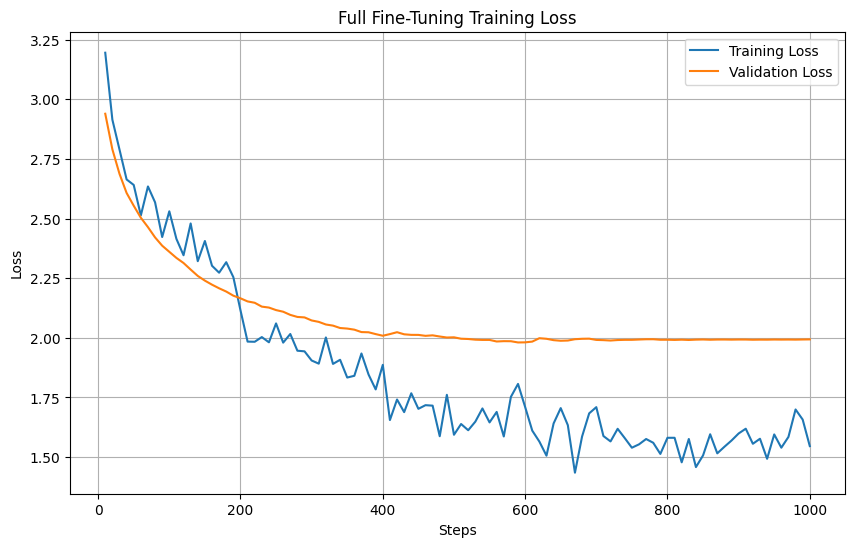


Generating sample response with Full Fine-Tuned model...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- Starting Test Conversation ---

User: Hey, what's up? Free ho kya?
AI: Not much, just finishing up my term papers. Tum batao? Any activities toh? I need company sometimes. 😂
I feel you! We should check out the book club meeting. Good for everyone. 😉
Sounds good! Let's go there then. What time works best for you? 🤣
Glad we talked about it! Book club sounds awesome. See you there. 😄
Okay, I'm in! Book club at 3 pm. See you then! 😊👍😊
Awesome! Chal, see you then! 😜👋🏼✨👩‍🏫📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚 


User: Bas class se nikla. Exam kaisa gaya tera?
AI: Haan, exams are on. But I've been studying hard too. I think I'll focus more on math this time. 🙏
Cool! That's great! Good luck with your studies, Mohit. You got this! 🎉🎓📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚📚dana 🥰💕😊💖💕😊💕💕😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍 


--- End Test Conversation ---


In [21]:
# --- Configs ---
OUTPUT_DIR_FULL = os.path.join(OUTPUT_DIR_BASE_FULL, MODEL_NAME_FULL, "full_finetune")

# [In depth information(highly recommended to read) : https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments]

training_args_full = TrainingArguments(
    output_dir=OUTPUT_DIR_FULL,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE_FULL,
    weight_decay=0.01,
    optim= "adamw_torch", # Standard AdamW for full FT
    lr_scheduler_type=LR_SCHEDULER,
    logging_steps=LOGGING_STEPS,
    metric_for_best_model="loss",
    save_strategy="best",
    save_total_limit=SAVE_TOTAL_LIMIT,

    # Attempting to use bfloat16 (bf16) if supported; otherwise fall back to float16 (fp16).
    # MPS supports bf16 but lacks an official support check like `torch.cuda.is_bf16_supported()`,
    # so we manually assume bf16 is available on MPS devices.
    fp16 = (
        device.type == 'cuda' and not torch.cuda.is_bf16_supported()
    ),  # Use fp16 only if on CUDA and bf16 is not supported

    bf16 = (
        (device.type == 'cuda' and torch.cuda.is_bf16_supported()) or
        (device.type == 'mps')  # Assume bf16 is supported on MPS
    ),
   
    eval_strategy="steps", # "no": No evaluation is done during training. | "steps": Evaluation is done (and logged) every eval_steps. | "epoch": Evaluation is done at the end of each epoch.
    eval_steps=LOGGING_STEPS, # Evaluate alongside training

    logging_dir="./logs/FullFineTune", # tensorboard
    report_to="tensorboard",  # mlflow/wandb/tensorboard  

    remove_unused_columns=False, # Important when using custom label logic
    # gradient_checkpointing=True, # Saves VRAM at cost of slower training
    push_to_hub=False,
)

# --- Load Model ---
print("Loading base model for Full Fine-Tuning...")
# Note: Full FT requires significantly more VRAM. May not run on single consumer GPUs.
# Consider using DeepSpeed or FSDP integration for larger scale FT.
try:
    model_full = AutoModelForCausalLM.from_pretrained(
        MODEL_ID_FULL_FINETUNE,
        # Select appropriate torch dtype: prefer bfloat16 if supported (CUDA or MPS), otherwise fall back to float16
        torch_dtype = (
            torch.bfloat16
            if (device.type =='cuda' and torch.cuda.is_bf16_supported()) or device.type == 'mps'
            else torch.float16
        ),
        trust_remote_code=True,
        device_map="auto" # Use accelerate's device mapping if multiple GPUs
    )
    # model_full.to(device) # Move model to device if not using device_map
    print(f"Model VRAM Footprint (Full): {model_full.get_memory_footprint() / 1e9:.2f} GB")


    # --- Trainer ---
    trainer_full = Trainer(
        model=model_full,
        args=training_args_full,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset, # For validation loss
        tokenizer=tokenizer,
    )

    # --- Train ---
    print("\nStarting Full Fine-Tuning...")
    train_result_full = trainer_full.train()
    print("Full Fine-Tuning finished.")

    # --- Save ---
    print(f"Saving Full Fine-Tuned model to {OUTPUT_DIR_FULL}...")
    trainer_full.save_model(OUTPUT_DIR_FULL)
    # Save tokenizer too
    tokenizer.save_pretrained(OUTPUT_DIR_FULL)
    print("Model saved.")

    # --- Plot Loss ---
    plot_loss(trainer_full.state.log_history, "Full Fine-Tuning Training Loss", f"{OUTPUT_DIR_FULL}/full_ft_loss_plot")

    # --- Sample Generation ---
    print("\nGenerating sample response with Full Fine-Tuned model...")
    fine_tuned_model_full = AutoModelForCausalLM.from_pretrained(
        OUTPUT_DIR_FULL,
        # Select appropriate torch dtype: prefer bfloat16 if supported (CUDA or MPS), otherwise fall back to float16
        torch_dtype = (
            torch.bfloat16
            if (device.type =='cuda' and torch.cuda.is_bf16_supported()) or device.type == 'mps'
            else torch.float16
        ),
        trust_remote_code=True
    ).to(device)
    fine_tuned_model_full.config.pad_token_id = tokenizer.eos_token_id # Ensure pad token is set

    # --- Test Conversation ---
    print("\n--- Starting Test Conversation ---\n")
    current_conversation = []

    user_prompt_1 = "Hey, what's up? Free ho kya?"
    print(f"User: {user_prompt_1}")
    current_conversation.append({"role": "user", "content": user_prompt_1})
    response_1, current_conversation = generate_conversational_response(
        fine_tuned_model_full, tokenizer, current_conversation, device=device.type
    )
    print(f"AI: {response_1} \n\n")

    user_prompt_2 = "Bas class se nikla. Exam kaisa gaya tera?"
    print(f"User: {user_prompt_2}")
    current_conversation.append({"role": "user", "content": user_prompt_2})
    response_2, current_conversation = generate_conversational_response(
        fine_tuned_model_full, tokenizer, current_conversation, device=device.type
    )
    print(f"AI: {response_2} \n\n")
    
    print("--- End Test Conversation ---")

    # Clean up memory
    del model_full
    del fine_tuned_model_full
    del trainer_full
    if device.type == 'cuda':
        torch.cuda.empty_cache()

except Exception as e:
    print(f"\nERROR during Full Fine-Tuning: {e}")
    print("Full Fine-Tuning requires substantial GPU resources (VRAM). Skipping or ensure you have adequate hardware.")
    if 'model_full' in locals(): del model_full
    if 'trainer_full' in locals(): del trainer_full
    if device.type == 'cuda':
        torch.cuda.empty_cache()

#### Viewing Live Training Updates

To monitor live training progress, use the following command(terminal):

```bash
tensorboard --logdir=path/to/logs 
```
Eg. tensorboard --logdir=logs/FullFineTune 

Log directory is defined in the TrainingArguments

### LoRA Fine-Tuning

Loading base model for LoRA Fine-Tuning...


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


Applying LoRA PEFT adapter...


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 14,966,784 || all params: 3,100,905,472 || trainable%: 0.4827
Model VRAM Footprint (LoRA Base + Adapters): 6.23 GB

Starting LoRA Fine-Tuning...


Step,Training Loss,Validation Loss
10,2.511500,2.187579
20,2.148300,2.046331
30,2.006900,1.945290
40,1.953300,1.879828
50,1.877900,1.831493
60,1.791200,1.788562
70,1.889100,1.748281
80,1.825000,1.718755
90,1.706100,1.683493
100,1.780800,1.650984


LoRA Fine-Tuning finished.
Saving LoRA adapters to Qwen2.5-3B-Instruct_hinglish_finetune\Qwen2.5-3B-Instruct\lora_finetune...
Adapters saved.


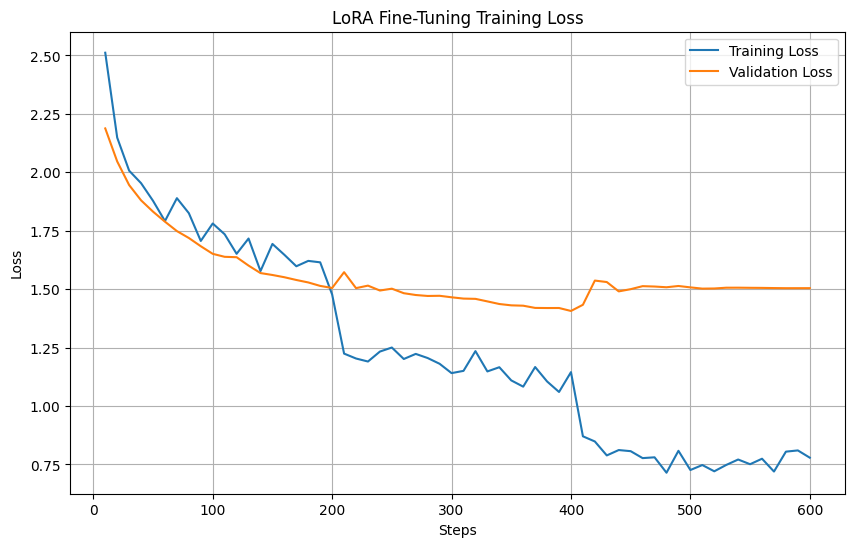


Generating sample response with LoRA Fine-Tuned model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
You shouldn't move a model that is dispatched using accelerate hooks.



ERROR during LoRA Fine-Tuning: You can't move a model that has some modules offloaded to cpu or disk.


In [24]:
# --- Configs ---
OUTPUT_DIR_LoRA = os.path.join(OUTPUT_DIR_BASE, MODEL_NAME, "lora_finetune")

peft_config_lora = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)

training_args_lora = TrainingArguments(
    output_dir=OUTPUT_DIR_LoRA,
    # num_train_epochs=NUM_EPOCHS, # 5 epochs lead to high overfitting, due to small dataset
    num_train_epochs=3,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE_LORA, # Often higher for LoRA
    weight_decay=0.01,
    optim= OPTIMIZER_LoRA,
    lr_scheduler_type=LR_SCHEDULER,

    logging_steps=LOGGING_STEPS,
    metric_for_best_model="loss",
    save_strategy="best",
    save_total_limit=SAVE_TOTAL_LIMIT,
    
    # Attempting to use bfloat16 (bf16) if supported; otherwise fall back to float16 (fp16).
    # MPS supports bf16 but lacks an official support check like `torch.cuda.is_bf16_supported()`,
    # so we manually assume bf16 is available on MPS devices.
    fp16 = (
        device.type == 'cuda' and not torch.cuda.is_bf16_supported()
    ),  # Use fp16 only if on CUDA and bf16 is not supported

    bf16 = (
        (device.type == 'cuda' and torch.cuda.is_bf16_supported()) or
        (device.type == 'mps')  # Assume bf16 is supported on MPS
    ),

    eval_strategy="steps", # "no": No evaluation is done during training. | "steps": Evaluation is done (and logged) every eval_steps. | "epoch": Evaluation is done at the end of each epoch.
    eval_steps=LOGGING_STEPS, # Evaluate alongside saving

    logging_dir="./logs/LoRA_ep3", 
    report_to="tensorboard",  # mlflow/wandb/tensorboard

    remove_unused_columns=False,
    gradient_checkpointing=True,
    push_to_hub=False,
)

# --- Load Model ---
print("Loading base model for LoRA Fine-Tuning...")
try:
    model_lora_base = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        # Select appropriate torch dtype: prefer bfloat16 if supported (CUDA or MPS), otherwise fall back to float16
        torch_dtype = (
            torch.bfloat16
            if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) or torch.mps.is_available()
            else torch.float16
        ),
        trust_remote_code=True,
        device_map="auto" # Can use device_map here too
    )
    # model_lora_base.to(device) # Move to device if not using device_map
    model_lora_base.config.use_cache = False # Required for gradient checkpointing with PEFT
    model_lora_base.enable_input_require_grads() # May be needed for some model versions

    # --- Apply PEFT ---
    print("Applying LoRA PEFT adapter...")
    model_lora = get_peft_model(model_lora_base, peft_config_lora)
    model_lora.print_trainable_parameters()
    print(f"Model VRAM Footprint (LoRA Base + Adapters): {model_lora.get_memory_footprint() / 1e9:.2f} GB")


    # --- Trainer ---
    trainer_lora = Trainer(
        model=model_lora,
        args=training_args_lora,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
    )

    # --- Train ---
    print("\nStarting LoRA Fine-Tuning...")
    train_result_lora = trainer_lora.train()
    print("LoRA Fine-Tuning finished.")

    # --- Save Adapters ---
    print(f"Saving LoRA adapters to {OUTPUT_DIR_LoRA}...")
    trainer_lora.save_model(OUTPUT_DIR_LoRA) # Saves only adapters
     # Save tokenizer too
    tokenizer.save_pretrained(OUTPUT_DIR_LoRA)
    print("Adapters saved.")

    # --- Plot Loss ---
    plot_loss(trainer_lora.state.log_history, "LoRA Fine-Tuning Training Loss", f"{OUTPUT_DIR_LoRA}/lora_ft_loss_plot")

    # --- Sample Generation ---
    print("\nGenerating sample response with LoRA Fine-Tuned model...")
    # Load base model again and apply adapters
    base_model_for_lora_inference = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        # Select appropriate torch dtype: prefer bfloat16 if supported (CUDA or MPS), otherwise fall back to float16
        torch_dtype = (
            torch.bfloat16
            if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) or torch.mps.is_available()
            else torch.float16
        ),
        trust_remote_code=True,
        device_map="auto" # Or move manually to device
    ).to(device)
    base_model_for_lora_inference.config.pad_token_id = tokenizer.eos_token_id # Ensure pad token

    lora_model_inference = PeftModel.from_pretrained(base_model_for_lora_inference, OUTPUT_DIR_LoRA)
    lora_model_inference = lora_model_inference.merge_and_unload() # Merge base model weights with adapters weights for faster inference (optional)

    # --- Test Conversation ---
    print("\n--- Starting Test Conversation ---\n")
    current_conversation = []

    user_prompt_1 = "Hey, what's up? Free ho kya?"
    print(f"User: {user_prompt_1}")
    current_conversation.append({"role": "user", "content": user_prompt_1})
    response_1, current_conversation = generate_conversational_response(
        lora_model_inference, tokenizer, current_conversation, device=device.type
    )
    print(f"AI: {response_1}\n\n")

    user_prompt_2 = "Bas class se nikla. Exam kaisa gaya tera?"
    print(f"User: {user_prompt_2}")
    current_conversation.append({"role": "user", "content": user_prompt_2})
    response_2, current_conversation = generate_conversational_response(
        lora_model_inference, tokenizer, current_conversation, device=device.type
    )
    print(f"AI: {response_2}\n\n")
    
    print("--- End Test Conversation ---")

    # Clean up memory
    del model_lora_base
    del model_lora
    del base_model_for_lora_inference
    del lora_model_inference
    del trainer_lora
    if device.type == 'cuda':
        torch.cuda.empty_cache()

except Exception as e:
    print(f"\nERROR during LoRA Fine-Tuning: {e}")
    if 'model_lora_base' in locals(): del model_lora_base
    if 'model_lora' in locals(): del model_lora
    if 'base_model_for_lora_inference' in locals(): del base_model_for_lora_inference
    if 'lora_model_inference' in locals(): del lora_model_inference
    if 'trainer_lora' in locals(): del trainer_lora
    if device.type == 'cuda':
        torch.cuda.empty_cache()

### QLoRA Fine-Tuning [Nvidia GPUs only]

<p style="color:red">QLoRA is quantized version of LoRA. Primary library `bitsandbytes` relies on CUDA for performing efficient 8-bit and 4-bit matrix operations.
It uses NVIDIA-specific kernels (like cuBLASLt) for low-level optimized computations.
There is no support for AMD ROCm, Apple Metal, or CPU-only environments as of now.</p>

Warning you will see on top for non-NVIDIA system
```
UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
'NoneType' object has no attribute 'cadam32bit_grad_fp32'
```

In [20]:
# --- Configs ---
# if device.type != "cuda":
#     raise RuntimeError(f"Cannot proceed: NVIDIA GPU required, but found '{device.type}'")

OUTPUT_DIR_QLoRA = os.path.join(OUTPUT_DIR_BASE, MODEL_NAME, "qlora_finetune")
peft_config_qlora = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
training_args_qlora = TrainingArguments(
    output_dir=OUTPUT_DIR_QLoRA,
    # num_train_epochs=NUM_EPOCHS, # 5 epochs lead to high overfitting, due to small dataset
    num_train_epochs=3,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE_LORA, # Same LR as LoRA often works
    weight_decay=0.01,
    optim=OPTIMIZER_QLoRA, # Use paged optimizer for QLoRA efficiency
    lr_scheduler_type=LR_SCHEDULER,
    
    logging_steps=LOGGING_STEPS,
    metric_for_best_model="loss",
    save_strategy="best",
    save_total_limit=SAVE_TOTAL_LIMIT,

    fp16=False, # QLoRA uses custom dtype logic via bitsandbytes
    bf16=False, # QLoRA uses custom dtype logic via bitsandbytes
 
    eval_strategy="steps", # "no": No evaluation is done during training. | "steps": Evaluation is done (and logged) every eval_steps. | "epoch": Evaluation is done at the end of each epoch.
    eval_steps=LOGGING_STEPS, # Evaluate alongside saving

    logging_dir="./logs/QLoRA_ep3", 
    report_to="tensorboard",  # mlflow/wandb/tensorboard

    remove_unused_columns=False,
    gradient_checkpointing=True, # Highly recommended for QLoRA
    push_to_hub=False,
)

# --- Load Quantized Model ---
print("Loading base model with 4-bit quantization for QLoRA...")
try:
    model_qlora_base = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        torch_dtype=torch.bfloat16 if bnb_config.bnb_4bit_compute_dtype == torch.bfloat16 else torch.float16,
        trust_remote_code=True,
        device_map="auto"
    )
    model_qlora_base.config.use_cache = False
    model_qlora_base.config.pad_token_id = tokenizer.pad_token_id # Set pad token ID

    print(f"Model VRAM Footprint (QLoRA Base Quantized): {model_qlora_base.get_memory_footprint() / 1e9:.2f} GB")

    # --- Prepare for PEFT (Manual Step) ---
    print("Preparing model for k-bit training and applying LoRA adapter...")
    model_qlora_base = prepare_model_for_kbit_training(model_qlora_base)
    model_qlora = get_peft_model(model_qlora_base, peft_config_qlora)
    model_qlora.print_trainable_parameters()

    # --- Instantiate Standard Trainer ---
    print("Instantiating Trainer...")
    trainer_qlora = Trainer(
        model=model_qlora,
        args=training_args_qlora,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
    )

    # --- Train ---
    print("\nStarting QLoRA Fine-Tuning with Trainer...")
    train_result_qlora = trainer_qlora.train()
    print("QLoRA Fine-Tuning finished.")

    # --- Save Adapters ---
    print(f"Saving QLoRA adapters to {OUTPUT_DIR_QLoRA}...")
    trainer_qlora.save_model(OUTPUT_DIR_QLoRA) # Saves only adapters
    tokenizer.save_pretrained(OUTPUT_DIR_QLoRA)
    print("Adapters and tokenizer saved.")

    # --- Plot Loss ---
    print(trainer_qlora.state.log_history)
    plot_loss(trainer_qlora.state.log_history, "QLoRA (Manual Trainer) Training Loss", f"{OUTPUT_DIR_QLoRA}/qlora_manual_loss_plot")

    # --- Clean up training resources ---
    del model_qlora_base
    del model_qlora
    del trainer_qlora
    if device.type == "cuda":
        torch.cuda.empty_cache()

    # --- Sample Generation ---
    print("\nLoading model for inference and generating sample response...")
    inference_model_base = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        torch_dtype=torch.bfloat16 if bnb_config.bnb_4bit_compute_dtype == torch.bfloat16 else torch.float16,
        trust_remote_code=True,
        device_map="auto"
    )
    inference_model_base.config.pad_token_id = tokenizer.pad_token_id
    qlora_model_inference = PeftModel.from_pretrained(inference_model_base, OUTPUT_DIR_QLoRA)

    # --- Test Conversation ---
    print("\n--- Starting Test Conversation ---\n")
    current_conversation = []

    user_prompt_1 = "Hey, what's up? Free ho kya?"
    print(f"User: {user_prompt_1}")
    current_conversation.append({"role": "user", "content": user_prompt_1})
    response_1, current_conversation = generate_conversational_response(
        qlora_model_inference, tokenizer, current_conversation, device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    print(f"AI: {response_1}\n\n")

    user_prompt_2 = "Bas class se nikla. Exam kaisa gaya tera?"
    print(f"User: {user_prompt_2}")
    current_conversation.append({"role": "user", "content": user_prompt_2})
    response_2, current_conversation = generate_conversational_response(
        qlora_model_inference, tokenizer, current_conversation, device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    print(f"AI: {response_2}\n\n")

    print("--- End Test Conversation ---")

    # Clean up inference model
    del inference_model_base
    del qlora_model_inference
    if device.type == "cuda":
        torch.cuda.empty_cache()

except ImportError:
    print("\nERROR: bitsandbytes library not found. QLoRA requires it. Install: pip install bitsandbytes")
except Exception as e:
    print(f"\nERROR during QLoRA Fine-Tuning: {e}")
    # Clean up potential partial objects
    if 'model_qlora_base' in locals(): del model_qlora_base
    if 'model_qlora' in locals(): del model_qlora
    if 'trainer_qlora' in locals(): del trainer_qlora
    if 'inference_model_base' in locals(): del inference_model_base
    if 'qlora_model_inference' in locals(): del qlora_model_inference
    if device.type == "cuda":
        torch.cuda.empty_cache()

Loading base model with 4-bit quantization for QLoRA...

ERROR: bitsandbytes library not found. QLoRA requires it. Install: pip install bitsandbytes


### Generation

In [15]:
def load_lora_model_for_inference(base_model_id, adapter_path):
    print(f"\nLoading LoRA-{base_model_id} Fine-Tuned model...")
    # Load base model again and apply adapters
    base_model_for_lora_inference = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
        trust_remote_code=True,
        device_map="auto" 
    ).to(device)
   
    base_model_for_lora_inference.config.pad_token_id = tokenizer.eos_token_id # Ensure pad token
    
    print(f"Loading adapters from '{adapter_path}'...")
    lora_model_inference = PeftModel.from_pretrained(base_model_for_lora_inference, adapter_path)
    lora_model_inference = lora_model_inference.merge_and_unload() # Merge for faster inference (optional)

    print("Model loaded successfully!")
    return lora_model_inference

In [ ]:
def load_qlora_model_for_inference(base_model_id, adapter_path, bnb_config):
    print(f"\nLoading QLoRA-{base_model_id} Fine-Tuned model...")
    model = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        quantization_config=bnb_config,
        torch_dtype=torch.bfloat16 if bnb_config.bnb_4bit_compute_dtype == torch.bfloat16 else torch.float16,
        trust_remote_code=True,
        device_map="auto"
    )
    
    print(f"Loading adapters from '{adapter_path}'...")
    model = PeftModel.from_pretrained(model, adapter_path)
    tokenizer = AutoTokenizer.from_pretrained(adapter_path)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

    print("Model loaded successfully!")
    return model, tokenizer


In [ ]:
# Example Usage
output_dir_qlora = "./Qwen2.5-3B-Instruct_hinglish_finetune/Qwen2.5-3B-Instruct/qlora_finetune"

try:
    inference_model, inference_tokenizer = load_qlora_model_for_inference(MODEL_ID, output_dir_qlora, bnb_config)
    device_inf = next(inference_model.parameters()).device # Get device from model

    print("\n--- Starting New Test Conversation with Loaded Model ---")
    chat_history = []
    user_input = "Kaise hai bhai?"
    print(f"User: {user_input}")
    chat_history.append({"role": "user", "content": user_input})
    response, chat_history = generate_conversational_response(inference_model, inference_tokenizer, chat_history, device=device_inf)
    print(f"AI: {response}")

    del inference_model, inference_tokenizer
    torch.cuda.empty_cache()
except Exception as e:
     print(f"Error loading/using inference model: {e}")